Goal

In this section,

We will learn about the basics of multiview geometry
We will see what is epipole, epipolar lines, epipolar constraint etc.

So first we need to find as many possible matches between two images to find the fundamental matrix. For this, we use SIFT descriptors with FLANN based matcher and ratio test.

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

img1 = cv.imread('fd_1_l.jpg',0)  #queryimage # left image
img2 = cv.imread('fd_1_r2.jpg',0) #trainimage # right image

sift = cv.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

pts1 = []
pts2 = []

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

Now we have the list of best matches from both the images. Let's find the Fundamental Matrix.

In [18]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)
print(F)

# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

[[-1.62721643e-08 -4.51844643e-07  2.32105458e-03]
 [ 4.71840648e-07 -3.47486542e-09  2.23202853e-03]
 [-2.50822859e-03 -2.40625617e-03  1.00000000e+00]]


Next we find the epilines. Epilines corresponding to the points in first image is drawn on second image. So mentioning of correct images are important here. We get an array of lines. So we define a new function to draw these lines on the images.

In [19]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

Now we find the epilines in both the images and draw them.

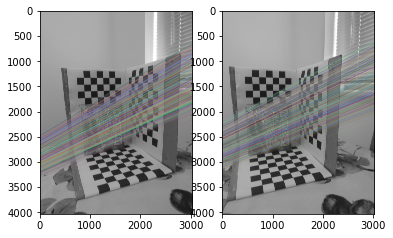

In [20]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)

plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

By selecting two lines from each of the line set and solve the equaions, we can easily get the epipoles.

In [21]:
def CrossPoint(l1,l2):
    a,b,c=l1
    d,e,f=l2
    return [(c*e-b*f)/(b*d-a*e),(a*f-c*d)/(b*d-a*e)]

epl1a=lines1[0]
epl1b=lines1[len(lines1)-1]
epp1=CrossPoint(epl1a,epl1b)
epp1=np.rint(epp1)
epp1=epp1.astype(int)
print("The position of the first picture's epipole is",epp1)

epl2a=lines2[0]
epl2b=lines2[len(lines2)-1]
epp2=CrossPoint(epl2a,epl2b)
epp2=np.rint(epp2)
epp2=epp2.astype(int)
print("The position of the second picture's epipole is",epp2)

The position of the first picture's epipole is [-4691  5306]
The position of the second picture's epipole is [-5365  5131]


Use stereoRectify function.

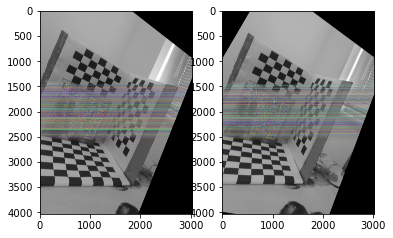

In [22]:
size=img1.shape[1],img1.shape[0]
retval, H1, H2=cv.stereoRectifyUncalibrated(pts1, pts2, F, size)

dst1=cv.warpPerspective(img5, H1,size)
#dst1 = cv.cvtColor(dst1,cv.COLOR_GRAY2BGR)

dst2=cv.warpPerspective(img3, H2,size)
#dst2 = cv.cvtColor(dst2,cv.COLOR_GRAY2BGR)

plt.subplot(121),plt.imshow(dst1)
plt.subplot(122),plt.imshow(dst2)
plt.show()

In [ ]:
cv.imwrite()